# Tarea 2 - Computación Cienctífica y Ciencia de los Datos
## Medio elástico discreto
### Vicente Mieres / 21.082.122-8

In [1]:
%matplotlib widget

In [14]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Parte 1 - Simulación de trayectoria

1.1 Funciones Principales

In [9]:
def matrix_init(n, k_const=1.0):
    N = n * n
    dim = 2 * N
    K = np.zeros((dim, dim))
    
    def idx(i, j, coord):
        masa = i * n + j
        return 2 * masa + coord

    for i in range(n):
        for j in range(n):
            for coord in [0,1]:
                diagonal_pos = idx(i,j,coord)
                suma_k_vecinos = 0
                vecinos = []
                if i+1 < n:
                    vecinos.append(idx(i+1,j,coord))
                    suma_k_vecinos += k_const
                if i-1 >= 0:
                    vecinos.append(idx(i-1,j,coord))
                    suma_k_vecinos += k_const
                if j+1 < n:
                    vecinos.append(idx(i,j+1,coord))
                    suma_k_vecinos += k_const
                if j-1 >= 0:
                    vecinos.append(idx(i,j-1,coord))
                    suma_k_vecinos += k_const
                
                K[diagonal_pos, diagonal_pos] = suma_k_vecinos
                for v in vecinos:
                    K[diagonal_pos, v] = -k_const
    return K


def get_values(K):
    eigvals, eigvecs = np.linalg.eig(K)

    # Ordenar por valor absoluto
    idx_sorted = np.argsort(np.abs(eigvals))
    eigvals = eigvals[idx_sorted]
    eigvecs = eigvecs[:, idx_sorted]

    # omega
    omega = np.sqrt(np.clip(eigvals, a_min=0, a_max=None))

    return eigvecs, omega

def simulate_trayectory(t_vect, R0, V0, A, omega):
    """
    Simula R(t) para cada tiempo en t_vect.

    Parámetros:
    - t_vect: array 1D con tiempos, shape (T,)
    - R0: vector condiciones iniciales posiciones, shape (D,)
    - V0: vector condiciones iniciales velocidades, shape (D,)
    - A: matriz autovectores, shape (D, D)
    - omega: vector frecuencias, shape (D,)

    Retorna:
    - Rt: array con resultados para cada t, shape (T, D)
    """

    D = R0.shape[0]
    T = t_vect.shape[0]

    AR0 = A.T @ R0      # Transformar R0 al espacio de autovectores
    AV0 = A.T @ V0      # Transformar V0 al espacio de autovectores

    omega_mat = omega.reshape((1, D))  # Reshape para aplicar la frecuencia sobre todos los tiempos
    t_mat = t_vect.reshape((T, 1))     # Reshape para aplicar los tiempos sobre todas las frecuencias
    
    f_t = np.cos(omega_mat * t_mat) 

    with np.errstate(divide='ignore', invalid='ignore'):
        g_t = np.where(omega_mat != 0,
                       np.sin(omega_mat * t_mat) / omega_mat,
                       t_mat) 
    term1 = f_t * AR0  
    term2 = g_t * AV0  
    
    R_t = term1 + term2  

    Rt = R_t @ A.T

    return Rt


def animation(Rt, n, t_vect, file_name, intervalo=20, margin=2):
    """
    Anima la malla de masas moviéndose con las posiciones Rt y muestra el centro de masa.
    
    Parámetros:
    - Rt: array con posiciones en cada tiempo, shape (T, 2*n^2)
    - n: tamaño de la malla (n x n)
    - t_vect: vector de tiempos (T,)
    - file_name: nombre del archivo de salida
    - intervalo: ms entre frames de animación
    """
    
    # Coordenadas iniciales en reposo, grilla regular
    x_eq = np.repeat(np.arange(n), n)
    y_eq = np.tile(np.arange(n), n)

    x_cm_initial = np.mean(x_eq)
    y_cm_initial = np.mean(y_eq)
    
    # Fijar límites de los ejes en base al centro de masa inicial

    fig, ax = plt.subplots(figsize=(6,6))
    # ax.set_xlim(-1, 10)
    ax.set_xlim(x_cm_initial - margin, x_cm_initial + margin)
    ax.set_ylim(y_cm_initial - margin, y_cm_initial + margin)
    # ax.set_ylim(-1, 10)
    ax.set_aspect('equal')
    ax.set_title("Simulación Movimiento Medio Elástico")
    ax.grid(True)



    # Scatter plot para posiciones (se actualizará)
    scat = ax.scatter(x_eq, y_eq, c='blue')
    
    # Punto para el centro de masa (inicialmente en el centro)
    center_of_mass, = ax.plot([], [], 'ro', markersize=8, label="Centro de masa")

    # Función para actualizar la animación
    def update(frame):
        R_t = Rt[frame]  # posiciones desplazadas en el tiempo
        x_t = x_eq + R_t[0::2]  # posiciones x + desplazamientos
        y_t = y_eq + R_t[1::2]  # posiciones y + desplazamientos
        
        # Actualiza las posiciones de las masas
        scat.set_offsets(np.c_[x_t, y_t])
        
        # Calcular el centro de masa en el tiempo t
        # El centro de masa es el promedio ponderado de las posiciones
        x_cm = np.mean(x_t)  # Promedio de las posiciones x
        y_cm = np.mean(y_t)  # Promedio de las posiciones y
        # print(x_cm, y_cm)
        
        # Actualizar la posición del centro de masa en la animación
        center_of_mass.set_data([x_cm], [y_cm])  # Pasamos como lista

        # Actualizar la etiqueta y el tiempo en el gráfico
        ax.set_xlabel(f"t = {t_vect[frame]:.2f} s")
        return scat, center_of_mass

    # Crear la animación
    anim = FuncAnimation(fig, update, frames=len(t_vect), interval=intervalo, blit=True)
    
    # Guardar la animación como GIF
    anim.save(f"{file_name}.gif", writer="ffmpeg", fps=30)

def generate_v0(n, amp=0.5):
    """
    Genera velocidades para el movimiento oscilatorio con el centro de masa en reposo o con desplazamiento.
    Alterna las velocidades en x y en y de forma que se compense el movimiento del centro de masa, o no.
    
    - n: tamaño de la malla (n x n)
    - amp: amplitud de las velocidades de oscilación
    """
    D = 2 * n * n  # tamaño del vector de velocidades (2n^2)
    V = np.zeros(D)  # Inicializar las velocidades en 0
    
    # Vectorizamos las asignaciones para las velocidades en x
    V[0::2] = amp * np.arange(n * n) % 2 * 2 - 1  # Alterna +amp y -amp en las posiciones x
    
    # Vectorizamos las asignaciones para las velocidades en y
    V[1::2] = amp * np.arange(n * n) // 2 % 2 * 2 - 1  # Alterna +amp y -amp en las posiciones y

    return V


## Experimentos con centro de masa estático

In [4]:
%%time
# Experimento 1 - n < 5
n = 4  # tamaño de la malla
K = matrix_init(n)

print(f"Dimensiones de la matríz K: {K.shape}")

# Calcular valores y vectores propios
eigvecs, omega = get_values(K)

# Condiciones iniciales
D = 2 * n * n
R0 = np.zeros(D) # posiciones iniciales en equilibrio
V0 = generate_v0(n=4, amp=1)

print(f"Vector con velocidades iniciales: {V0}")

vx_total = np.sum(V0[0::2])  # suma de las velocidades en x
vy_total = np.sum(V0[1::2])  # suma de las velocidades en y

print("Suma velocidades en x:", vx_total)
print("Suma velocidades en y:", vy_total)

# Vector de tiempos
t_vect = np.linspace(0, 10, 500)

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (4,4) (13,) 

In [5]:
%%time
# Simular trayectoria
Rt = simulate_trayectory(t_vect, R0, V0, eigvecs, omega)

CPU times: total: 0 ns
Wall time: 1 ms


MovieWriter ffmpeg unavailable; using Pillow instead.


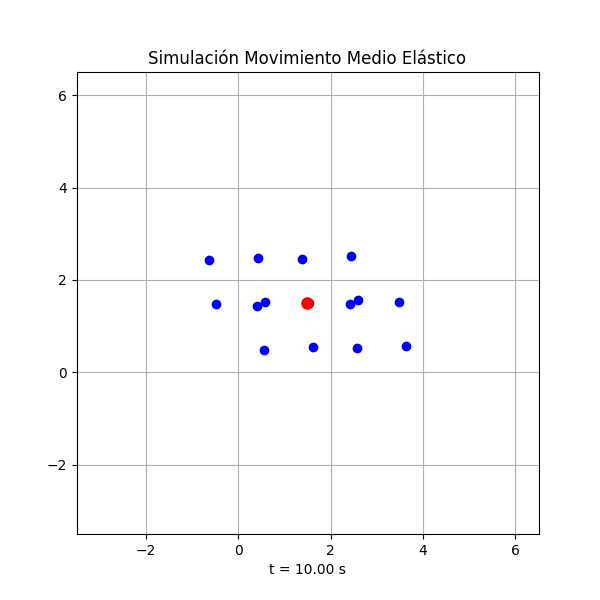

In [ ]:
%%time
animation(Rt, 4, t_vect, "experimento_1")

In [11]:
%%time
# Experimento 2 - n e [5,10]

n = 9  # tamaño de la malla
K = matrix_init(n)

print(f"Dimensiones de la matríz K: {K.shape}")

# Calcular valores y vectores propios
eigvecs, omega = get_values(K)

# Condiciones iniciales
D = 2 * n * n
R0 = np.zeros(D) # posiciones iniciales en equilibrio
V0 = generate_v0(n=9, amp=1)
# Esta modificacion solo se hace para que la suma quede en 0.0 y por tanto el centro de masas estático
V0[(n * n) // 2] = 0
V0[(n * n)  - 1 // 2] = 0

print(f"Vector con velocidades iniciales: {V0}")

vx_total = np.sum(V0[0::2])  # suma de las velocidades en x
vy_total = np.sum(V0[1::2])  # suma de las velocidades en y

print("Suma velocidades en x:", vx_total)
print("Suma velocidades en y:", vy_total)

# Vector de tiempos
t_vect = np.linspace(0, 10, 500)

Dimensiones de la matríz K: (162, 162)
Vector con velocidades iniciales: [-1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.
  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1.
 -1.  1.  1.  1.  0. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.
  1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.
 -1. -1.  1. -1. -1.  1.  1.  1. -1.  0.  1. -1. -1.  1.  1.  1. -1. -1.
  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1.
 -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.
  1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.
 -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.]
Suma velocidades en x: 0.0
Suma velocidades en y: 0.0
CPU times: total: 31.2 ms
Wall time: 35 ms


In [12]:
%%time
# Simular trayectoria
Rt = simulate_trayectory(t_vect, R0, V0, eigvecs, omega)
print(f"forma del vector R(t): {Rt.shape}")

forma del vector R(t): (500, 162)
CPU times: total: 31.2 ms
Wall time: 19 ms


c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:558: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asanyarray(self.convert_xunits(offsets[:, 0]), float),
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:559: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asanyarray(self.convert_yunits(offsets[:, 1]), float)))
MovieWriter ffmpeg unavailable; using Pillow instead.
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:558: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asanyarray(self.convert_xunits(offsets[:, 0]), float),
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:559: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asanyarray(self.convert_yunits(offsets[:, 

CPU times: total: 54.7 s
Wall time: 1min 2s


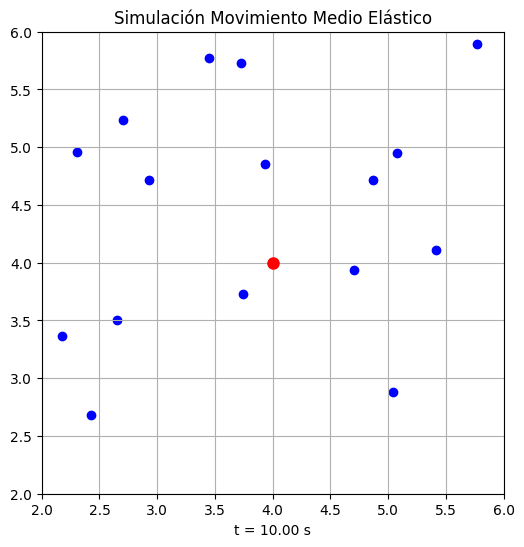

In [15]:
%%time
animation(Rt, 9, t_vect, "experimento_2")

In [ ]:
%time
# Experimento 3 - n e [50,100]

n = 61  # tamaño de la malla
K = matrix_init(n)

print(f"Dimensiones de la matríz K: {K.shape}")

# Calcular valores y vectores propios
eigvecs, omega = get_values(K)

# Condiciones iniciales
D = 2 * n * n
R0 = np.zeros(D) # posiciones iniciales en equilibrio
V0 = generate_v0(n=61, amp=1)
# Esta modificacion solo se hace para que la suma quede en 0.0 y por tanto el centro de masas estático
V0[(n * n) // 2] = 0
V0[(n * n)  - 1 // 2] = 0

print(f"Vector con velocidades iniciales: {V0}")

vx_total = np.sum(V0[0::2])  # suma de las velocidades en x
vy_total = np.sum(V0[1::2])  # suma de las velocidades en y

print("Suma velocidades en x:", vx_total)
print("Suma velocidades en y:", vy_total)

# Vector de tiempos
t_vect = np.linspace(0, 10, 300)

CPU times: total: 0 ns
Wall time: 0 ns
Dimensiones de la matríz K: (7442, 7442)


In [ ]:
%%time
# Simular trayectoria
Rt = simulate_trayectory(t_vect, R0, V0, eigvecs, omega)
print(f"forma del vector R(t): {Rt.shape}")

In [ ]:
%%time
animation(Rt, 9, t_vect, "experimento_3")

## Experimentos con centro de masa oscilatorio

In [13]:
%time
# Experimento 4 - n < 5

n = 3 # tamaño de la malla
K = matrix_init(n)

print(f"Dimensiones de la matríz K: {K.shape}")

# Calcular valores y vectores propios
eigvecs, omega = get_values(K)

# Condiciones iniciales
D = 2 * n * n
R0 = np.zeros(D) # posiciones iniciales en equilibrio
V0 = np.zeros(D)
V0[2*n*n//2] = 2

print(f"Vector con velocidades iniciales: {V0}")

vx_total = np.sum(V0[0::2])  # suma de las velocidades en x
vy_total = np.sum(V0[1::2])  # suma de las velocidades en y

print("Suma velocidades en x:", vx_total)
print("Suma velocidades en y:", vy_total)

# Vector de tiempos
t_vect = np.linspace(0, 10, 500)

CPU times: total: 0 ns
Wall time: 0 ns
Dimensiones de la matríz K: (18, 18)
Vector con velocidades iniciales: [0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
Suma velocidades en x: 0.0
Suma velocidades en y: 2.0


In [14]:
%%time
# Simular trayectoria
Rt = simulate_trayectory(t_vect, R0, V0, eigvecs, omega)
print(f"forma del vector R(t): {Rt.shape}")

forma del vector R(t): (500, 18)
CPU times: total: 0 ns
Wall time: 2.02 ms


MovieWriter ffmpeg unavailable; using Pillow instead.
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:558: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asanyarray(self.convert_xunits(offsets[:, 0]), float),
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:559: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asanyarray(self.convert_yunits(offsets[:, 1]), float)))
c:\Users\vicen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


CPU times: total: 32.1 s
Wall time: 33.7 s


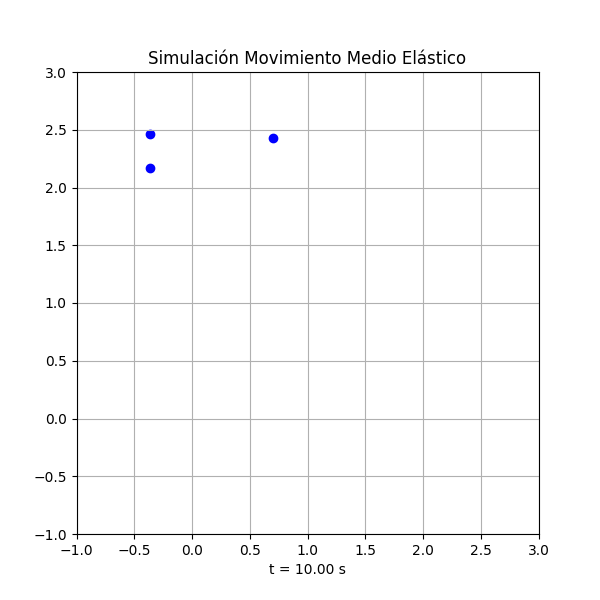

In [15]:
%%time
animation(Rt, 3, t_vect, "experimento_4")

In [59]:
%time
# Experimento 5 - n e [5,10]

n = 7 # tamaño de la malla
K = matrix_init(n)

print(f"Dimensiones de la matríz K: {K.shape}")

# Calcular valores y vectores propios
eigvecs, omega = get_values(K)

# Condiciones iniciales
D = 2 * n * n
R0 = np.zeros(D) # posiciones iniciales en equilibrio
V0 = np.zeros(D)
V0[2*n*n//2 + 1] = 1
V0[2*n*n//2 - 1] = 1

print(f"Vector con velocidades iniciales: {V0}")

vx_total = np.sum(V0[0::2])  # suma de las velocidades en x
vy_total = np.sum(V0[1::2])  # suma de las velocidades en y

print("Suma velocidades en x:", vx_total)
print("Suma velocidades en y:", vy_total)

# Vector de tiempos
t_vect = np.linspace(0, 10, 500)

CPU times: total: 0 ns
Wall time: 0 ns
Dimensiones de la matríz K: (98, 98)
Vector con velocidades iniciales: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Suma velocidades en x: 2.0
Suma velocidades en y: 0.0


In [60]:
%%time
# Simular trayectoria
Rt = simulate_trayectory(t_vect, R0, V0, eigvecs, omega)
print(f"forma del vector R(t): {Rt.shape}")

forma del vector R(t): (500, 98)
CPU times: total: 0 ns
Wall time: 1.99 ms


MovieWriter ffmpeg unavailable; using Pillow instead.


CPU times: total: 47 s
Wall time: 50.3 s


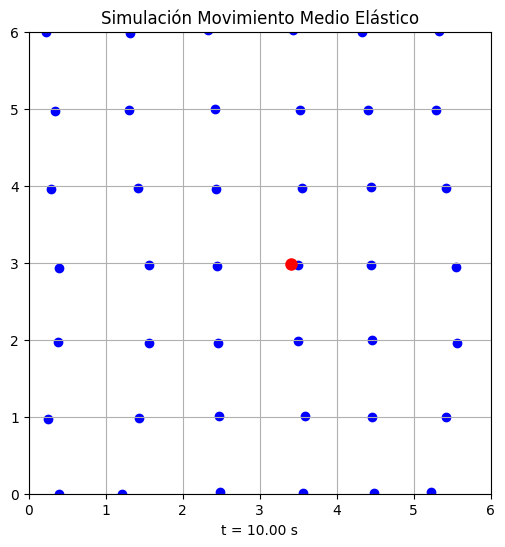

In [65]:
%%time
animation(Rt, 7, t_vect, "experimento_5", margin=3)

In [ ]:
%time
# Experimento 6 - n e [50,100]

n = 55 # tamaño de la malla
K = matrix_init(n)

print(f"Dimensiones de la matríz K: {K.shape}")

# Calcular valores y vectores propios
eigvecs, omega = get_values(K)

# Condiciones iniciales
D = 2 * n * n
R0 = np.zeros(D) # posiciones iniciales en equilibrio
V0 = generate_v0(55, amp=0.5)


print(f"Vector con velocidades iniciales: {V0}")

vx_total = np.sum(V0[0::2])  # suma de las velocidades en x
vy_total = np.sum(V0[1::2])  # suma de las velocidades en y

print("Suma velocidades en x:", vx_total)
print("Suma velocidades en y:", vy_total)

# Vector de tiempos
t_vect = np.linspace(0, 20, 600)

CPU times: total: 0 ns
Wall time: 0 ns
Dimensiones de la matríz K: (6050, 6050)


In [ ]:
%%time
# Simular trayectoria
Rt = simulate_trayectory(t_vect, R0, V0, eigvecs, omega)
print(f"forma del vector R(t): {Rt.shape}")

In [ ]:
%%time
animation(Rt, 51, t_vect, "experimento_6", margin=5)